In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install detectron2 dependencies

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15771 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 21.85 MiB/s, done.
Resolving deltas: 100% (11532/11532), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your e

In [ ]:


import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image as PILImage
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from collections import Counter
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor


In [ ]:
resize_to = (224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Model Setup Summary

This section sets up the classification and segmentation models used in the coin recognition pipeline:



####  **Classifier Model**

- **Image Size:** All input coin crops are resized to 224×224 pixels to match the training input.
- **Heads:**
  -   `UK Head`: Binary classifier (`UK` vs `Non-UK`)
  - `Side Head`: Binary classifier (`Heads` vs `Tails`)
  - `Denomination Head`: Multi-class classifier (`2p`, `1p`, `5p`)
- **Weights:** Loaded from `coin_classifier_final.pth` (trained separately).
- **Preprocessing:** Normalization with `[0.5]` mean and std (to match training pipeline).

---

####  **Segmentation Model**
- **Backbone:** `Mask R-CNN` with `ResNet-50 FPN` ( Detectron2)
- **Custom Weights:** Loaded from `model_final.pth`
- **Classes:** 1 class (`coin`)
- **Threshold:** Detection score threshold set to 0.5
- **Function:** Detects and segments coins from original dataset  input images to be passed to the classifier.


In [ ]:
import timm
#import torch.nn as nn

class CoinClassifier(nn.Module):
    def __init__(self, num_denom_classes):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b0", pretrained=False)
        self.feature_dim = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()

        self.uk_head = nn.Linear(self.feature_dim, 2)
        self.side_head = nn.Linear(self.feature_dim, 2)
        self.denom_head = nn.Linear(self.feature_dim, num_denom_classes)

    def forward(self, x):
        feats = self.backbone(x)
        return {
            'uk': self.uk_head(feats),
            'side': self.side_head(feats),
            'denomination': self.denom_head(feats)
        }

In [ ]:
# denomination class list  match training
denom_classes = ['2p', '1p', 'Unknown', '5p', '10p', '20p']
#Loading classifier model
model = CoinClassifier(num_denom_classes=len(denom_classes)).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Hexcel_Company_Project/Classifier_model/coin_classifier_final.pth", map_location=device))
model.eval()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
#loading the segementation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/hexcel/models-seg/model/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

# ***Data set questions:***
1.	Create a distribution plot for each image set, showing the total sterling value of coins in each image, ignore all coins that are not UK currency

2.	Create distributions showing the percentage of ‘heads’


###  Dataset Coin Analysis

This loop processes all images in both dataset folders (`d1`, `d2`) to perform full coin segmentation and classification. For each image, the following steps are performed:


####  **Image Processing Pipeline**
1. **Image Loading**: Each image is read using OpenCV and passed to the segmentation model.
2. **Coin Detection**: The `Mask R-CNN` model detects and segments individual coins in the image.
3. **Coin Classification**:
   - Each segmented coin is:
     - Masked onto a white background
     - Resized to `128×128` pixels
     - Passed through the classifier model (EfficientNet-B0)
   - Predictions include:
     - **UK / Non-UK status**
     - **Coin side** (`Heads` or `Tails`)
     - **Denomination** (if UK)



####  **Metrics Computed per Image**
- **Total Sterling Value**: Sum of all UK coin values in the image.
- **Heads Percentage**: % of all detected coins predicted as `Heads`.
- **Denomination Count**: Tally of predicted UK denominations.
- **Coin Count**: Total number of coins detected in the image.


 All per-image results are stored in the `results` dictionary for later export, visualization, and reporting.


In [ ]:
denomination_values = {
    '1p': 0.01, '2p': 0.02, '5p': 0.05,
    '10p': 0.10, '20p': 0.20, '50p': 0.50,
    '£1': 1.00, '£2': 2.00, 'Unknown': 0.00
}


In [ ]:
dataset_dirs = {
    "d1": "/content/drive/MyDrive/Hexcel_Company_Project/Submission/dataset2_2025ECPb/dataset1",
    "d2": "/content/drive/MyDrive/Hexcel_Company_Project/Submission/dataset2_2025ECPb/dataset2"
}
#d1 -> Dataset1 folder
#d2 -> Dataset2 folder

In [ ]:
results = {
    "d1": {"image_names": [], "values": [], "heads_percent": [], "coin_counts": [], "denom_counter": Counter()},
    "d2": {"image_names": [], "values": [], "heads_percent": [], "coin_counts": [], "denom_counter": Counter()}
}


In [ ]:
for dataset_name, folder_path in dataset_dirs.items():
    print(f"\n Processing dataset: {dataset_name.upper()}")
    image_list = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))])

    for img_name in tqdm(image_list):
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path)
        outputs = predictor(image)
        instances = outputs["instances"].to("cpu")
        masks = instances.pred_masks.numpy()
        boxes = instances.pred_boxes.tensor.numpy()

        uk_values = []
        head_count = 0
        tail_count = 0

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            x1, y1 = max(x1 - 5, 0), max(y1 - 5, 0)
            x2, y2 = min(x2 + 5, image.shape[1]), min(y2 + 5, image.shape[0])

            coin_img = image[y1:y2, x1:x2]
            coin_mask = masks[i][y1:y2, x1:x2].astype(np.uint8)
            white_bg = np.ones_like(coin_img) * 255
            masked_coin = np.where(coin_mask[:, :, None] == 1, coin_img, white_bg)
            resized = cv2.resize(masked_coin, (128, 128))

            pil_img = PILImage.fromarray(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
            input_tensor = transform(pil_img).unsqueeze(0).to(device)

            with torch.no_grad():
                out = model(input_tensor)
                uk_pred = torch.argmax(out['uk'], dim=1).item()
                side_pred = torch.argmax(out['side'], dim=1).item()
                side = "Heads" if side_pred == 1 else "Tails"

                if uk_pred == 1:
                    denom_pred = torch.argmax(out['denomination'], dim=1).item()
                    denom = denom_classes[denom_pred]
                    value = denomination_values.get(denom, 0.0)
                    uk_values.append(value)
                    results[dataset_name]["denom_counter"][denom] += 1

                if side == "Heads":
                    head_count += 1
                else:
                    tail_count += 1

        total_value = round(sum(uk_values), 2)
        total_faces = head_count + tail_count
        heads_percent = (head_count / total_faces) * 100 if total_faces > 0 else 0

        # store results
        results[dataset_name]["image_names"].append(img_name)
        results[dataset_name]["values"].append(total_value)
        results[dataset_name]["heads_percent"].append(round(heads_percent, 2))
        results[dataset_name]["coin_counts"].append(len(boxes))


 Processing dataset: D1


100%|██████████| 400/400 [00:46<00:00,  8.58it/s]



 Processing dataset: D2


100%|██████████| 399/399 [00:57<00:00,  6.92it/s]


In [ ]:
#csv
all_data = []
for dataset_name in results:
    for img_name, val, heads in zip(results[dataset_name]["image_names"], results[dataset_name]["values"], results[dataset_name]["heads_percent"]):
        all_data.append({
            "dataset": dataset_name,
            "image_name": img_name,
            "total_value": val,
            "heads_percent": heads
        })

df = pd.DataFrame(all_data)
df.to_csv("/content/drive/MyDrive/Hexcel_Company_Project/coin_analysis_results.csv", index=False)
print("\n  saved to CSV")



  saved to CSV


### Plotting Utility Functions

 A set of reusable plotting functions used to visualize various aspects of the coin classification results. These functions help summarize dataset characteristics in a clear and consistent format suitable for reports and analysis.

---

#### `plot_histogram_()`
A general-purpose function for generating histograms. It is used to visualize numeric distributions such as coin values, coin counts per image, or the percentage of 'heads'.

---

#### `plot_coin_count_distribution()`
Generates a histogram showing the number of coins detected per image. This distribution helps assess the variability in coin count across images within each dataset.

---

#### `plot_denomination_distribution()`
Creates a bar chart summarizing the frequency of each predicted UK coin denomination.The denominations are ordered by their monetary value to provide a meaningful overview of coin type distribution across the dataset.

---

#### `plot_value_cdf()`
Plots the cumulative distribution of total UK coin value per image for each dataset. This visualization helps interpret how total value is distributed, indicating what proportion of images fall below specific value thresholds.

---

Hence, these functions support the exploratory analysis and evaluation of model outputs, and they contribute to generating figures.


In [ ]:
def plot_histogram_(data, title, xlabel, ylabel, bins=10):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data, bins=bins, kde=False, color="#4A90E2", edgecolor="black")
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(f'{height}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=11)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_coin_count_distribution(results, dataset_name):
    plot_histogram_(
        data=results[dataset_name]["coin_counts"],
        title=f"Coin Count Distribution – {dataset_name.upper()}",
        xlabel="Number of Coins per Image",
        ylabel="Image Count",
        bins=15
    )


In [ ]:
def plot_denomination_distribution(counter, dataset_name):
    denom_order = sorted(counter.keys(), key=lambda d: denomination_values.get(d, 0))
    counts = [counter[d] for d in denom_order]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=denom_order, y=counts, palette="coolwarm", edgecolor="black")
    plt.title(f"Denomination Frequency – {dataset_name.upper()}", fontsize=16, fontweight='bold')
    plt.xlabel("Denomination", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_value_cdf(results):
    plt.figure(figsize=(10, 6))
    for key, label in zip(["d1", "d2"], ["Dataset 1", "Dataset 2"]):
        sns.ecdfplot(results[key]["values"], label=label)
    plt.title("Cumulative Distribution of UK Coin Value", fontsize=16, fontweight='bold')
    plt.xlabel("Total Coin Value (£)", fontsize=14)
    plt.ylabel("Cumulative Percentage", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


# UK Coin Value Distribution

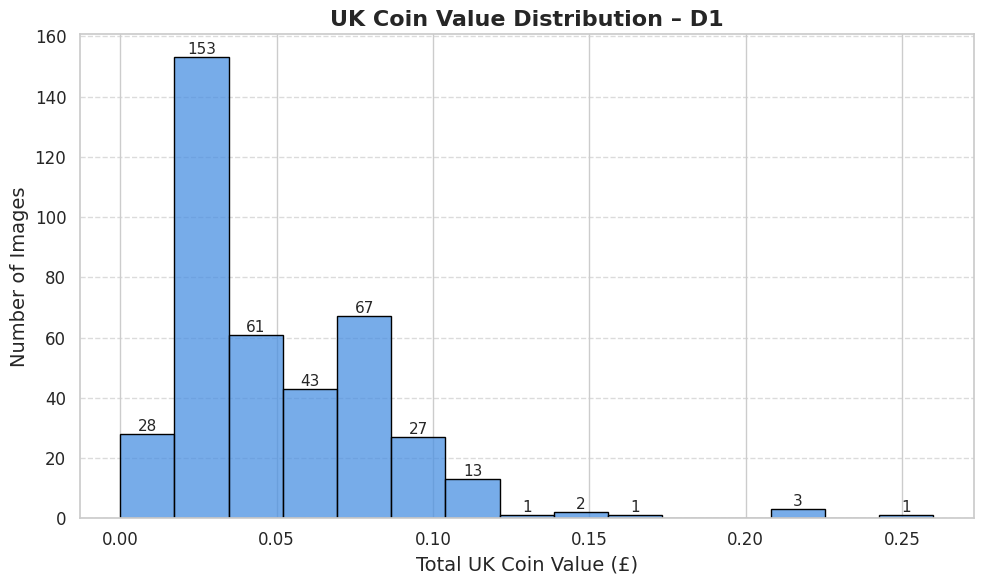

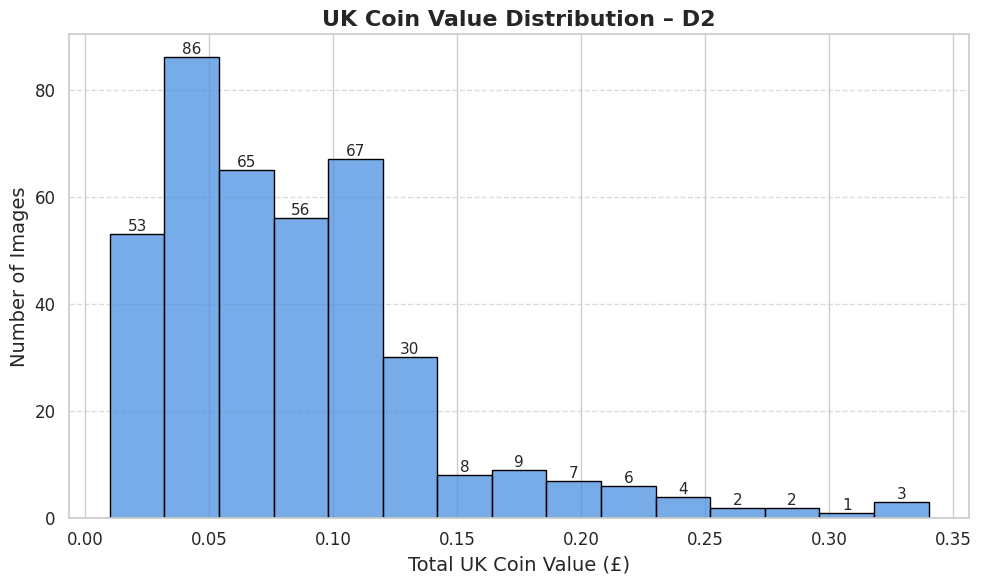

In [ ]:
# UK Coin Value Distribution
for dataset in ["d1", "d2"]:
    plot_histogram_(
        results[dataset]["values"],
        f"UK Coin Value Distribution – {dataset.upper()}",
        "Total UK Coin Value (£)",
        "Number of Images",
        bins=15
    )


### Analysis of UK Coin Value Distributions

The plots above present histograms of the total UK coin value per image in the two datasets:



#### **Dataset D1**
- The distribution is heavily concentrated in the lower range, with the majority of images containing a total value between **£0.03 and £0.06**.
- Approximately 60% of the images have a total value below **£0.10**, indicating a prevalence of low-value, fewer coins compared to Dataset2.
- Very few images exceed **£0.15**, showing minimal presence of higher-value denominations or dense coin groupings.




#### **Dataset D2**
- While the peak also occurs between **£0.03 and £0.06**, the overall distribution is broader and more varied than D1.
- A significant number of images reach total values above **£0.15**, with some extending beyond **£0.30**.
- This indicates that D2 likely contains more coins per image or includes higher-denomination UK coins more frequently.



#### Summary
- **D1** consists of simpler or lower-value coin groupings.
- **D2** presents more variability in total coin value, suggesting a more complex dataset .
- These differences are relevant when comparing model performance across datasets or evaluating generalization, as the distribution of UK coin values may influence classification outcomes specially the quility of the 2 datasets is different.


# Heads Percentage Distribution

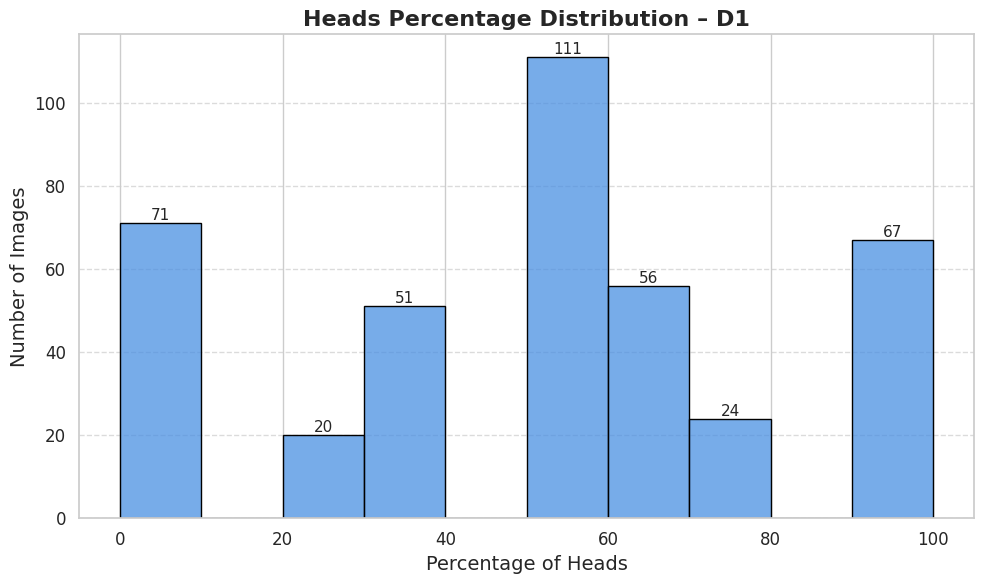

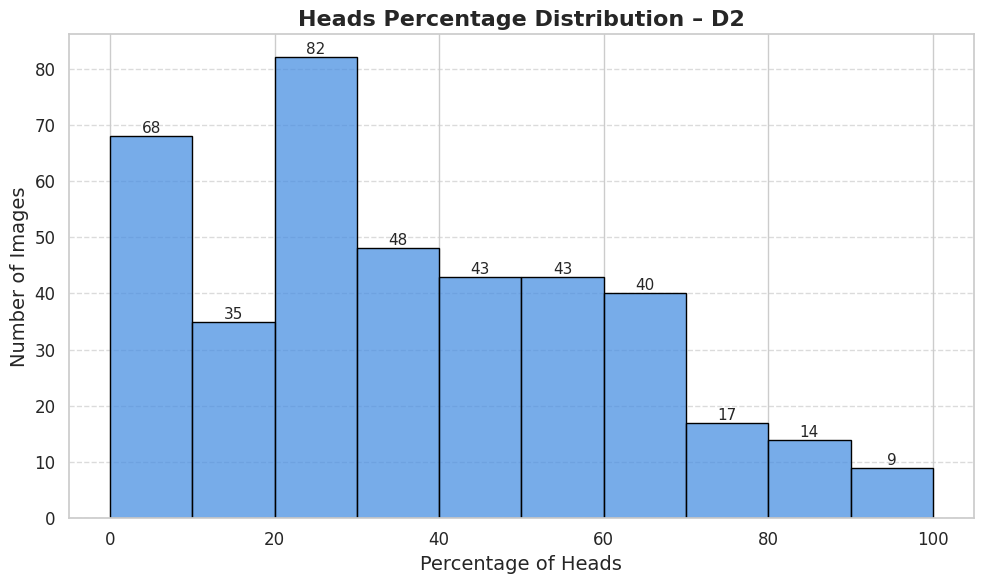

In [ ]:
# Heads Percentage Distribution
for dataset in ["d1", "d2"]:
    plot_histogram_(
        results[dataset]["heads_percent"],
        f"Heads Percentage Distribution – {dataset.upper()}",
        "Percentage of Heads",
        "Number of Images",
        bins=10
    )


### Analysis of Heads Percentage Distributions

The above histograms illustrate the distribution of the percentage of coins identified as "heads" per image in both datasets and for UK and NON-UK coins:


#### **Dataset D1**
- The distribution shows a ** central peak** between **50% and 60% heads**, with 111 images in that range.
- There are also two secondary peaks at **0%** and **100% heads**, suggesting that many images contain either all "tails" or all "heads".
- The overall pattern suggests some images are uniformly one side, while others contain a mix.
- This spread highlights some variation in coin orientation across the dataset, though many images are close to a balanced split.



#### **Dataset D2**
- The heads percentage in D2 appears **more uniformly distributed** compared to D1.
- The most frequent range is **20% to 30% heads**, followed by a  decline across higher bins.
- There is no dominant peak, and the distribution is relatively flat, suggesting more **random orientation** of coins.
- The dataset includes a wide variety of heads-to-tails ratios, indicating less consistency  compared to D1.


#### Summary
- **D1** includes several images with entirely one-sided coins and a noticeable concentration near a 50/50 split.
- **D2** presents more **diverse and less structured orientations**, which may reflect more n uncontrolled image settings.



# Further Analysis Conducted

# Coin Count Distribution

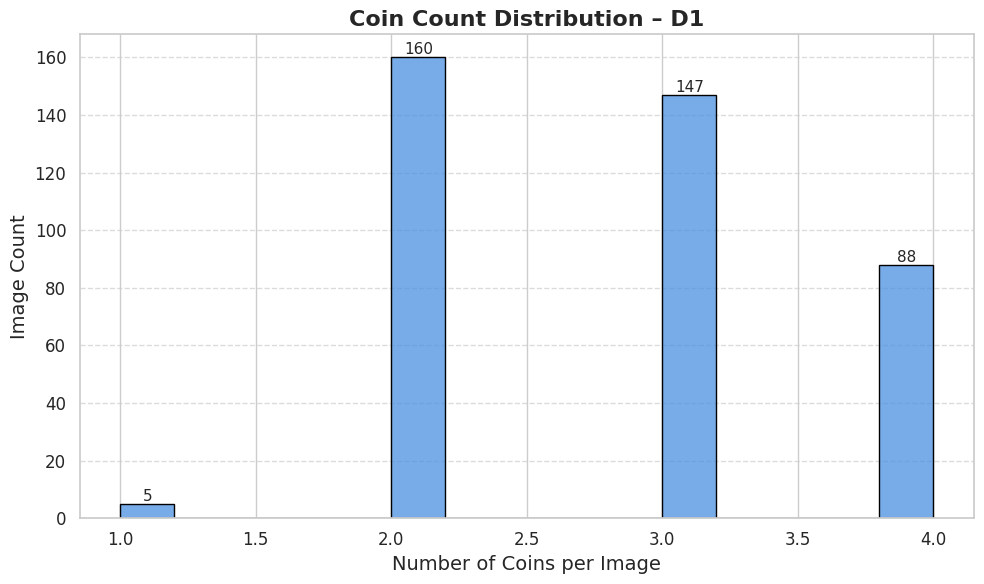

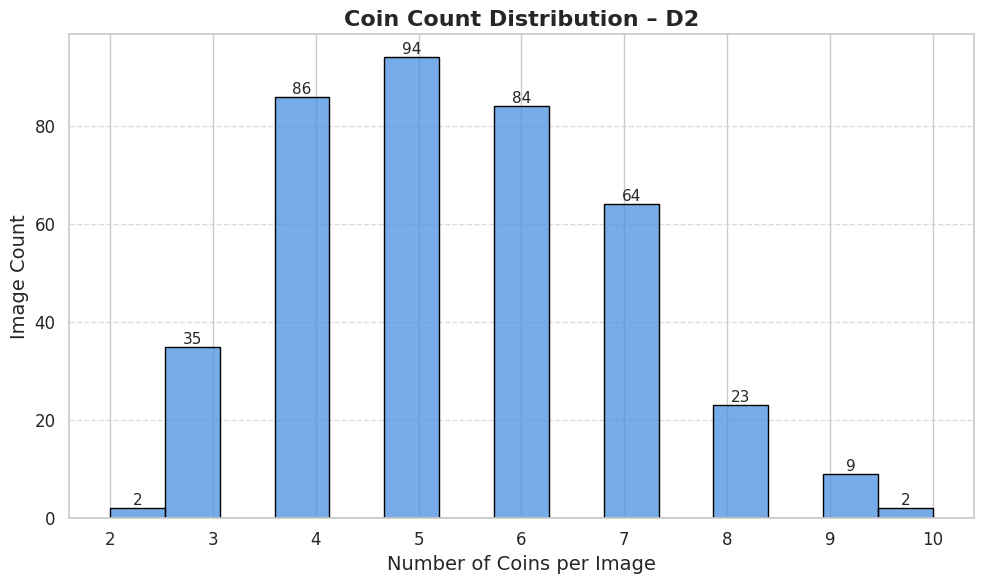

In [ ]:
# Coin Count per Image Distribution
for dataset in ["d1", "d2"]:
    plot_coin_count_distribution(results, dataset)


# Denomination Frequency

<ipython-input-49-bb496dd621ce>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=denom_order, y=counts, palette="coolwarm", edgecolor="black")


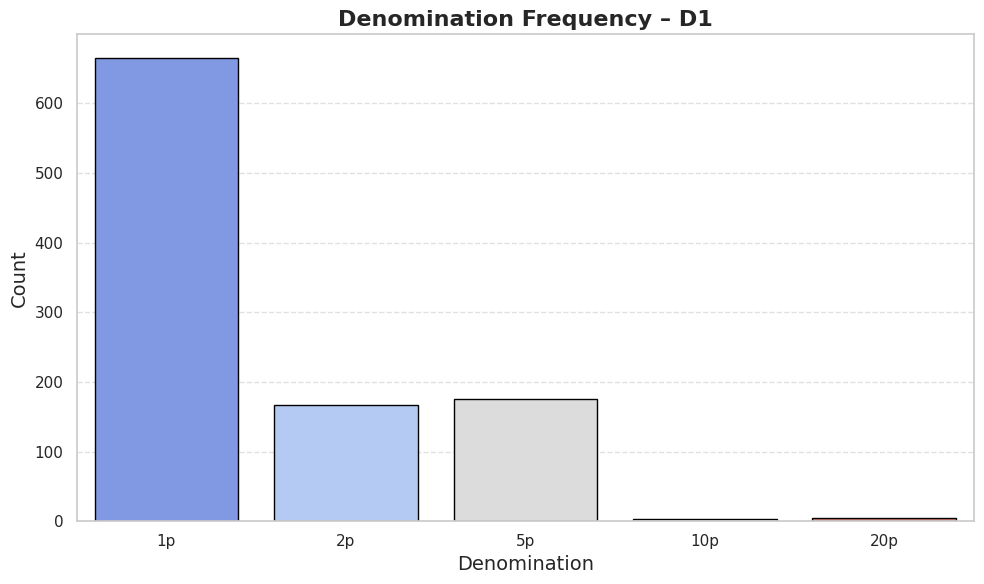

<ipython-input-49-bb496dd621ce>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=denom_order, y=counts, palette="coolwarm", edgecolor="black")


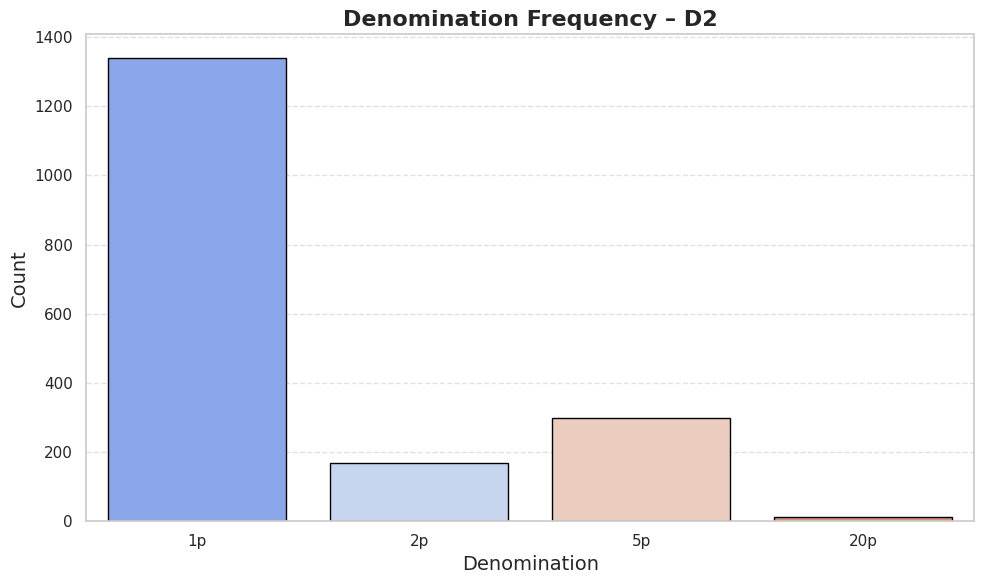

In [ ]:
# UK Coin Denomination Frequency
for dataset in ["d1", "d2"]:
    plot_denomination_distribution(results[dataset]["denom_counter"], dataset)


# Cumulative Distribution of Value (Combined)

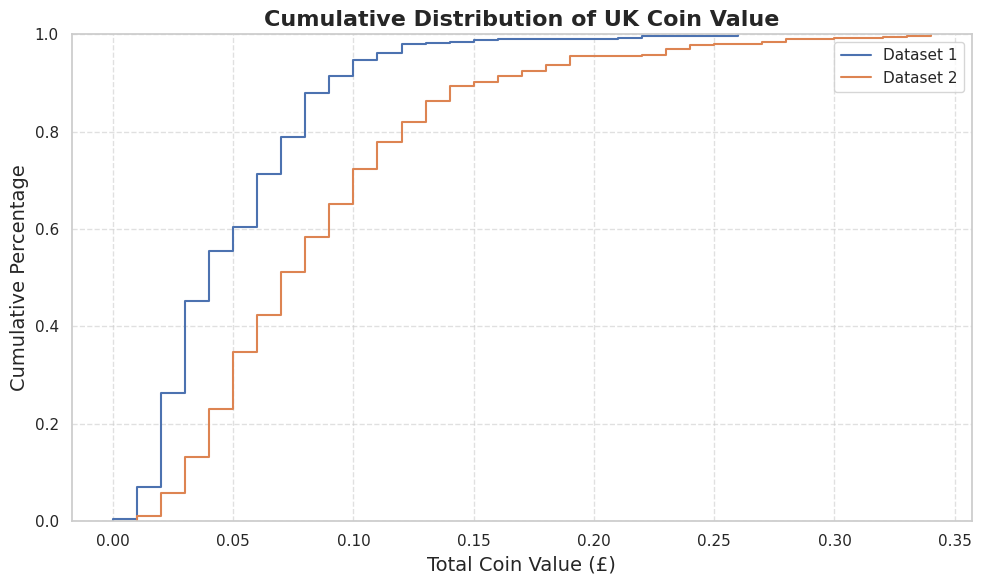

In [ ]:
plot_value_cdf(results)

# Coin Distribution Analysis

#### 1. Coin Count Distribution
- **Dataset D1** displays a narrower distribution of coin counts per image, with most images containing 2 or 3 coins.
- **Dataset D2**, in contrast, shows a broader distribution, with coin counts ranging from 2 to 10 per image. Most commonly, images contain between 4 and 6 coins.
- This indicates that D2 contains more crowded and complex scenes compared to D1.

#### 2. Denomination Frequency
- Both datasets are heavily dominated by **1p coins**, which constitute the majority of UK coin detections.
- D1 and D2 share similar secondary distributions, with **2p** and **5p** coins also occurring frequently.
- Higher denomination coins such as **10p** and **20p** are minimally represented

#### 3. Cumulative Distribution of Total Coin Value
- The **cumulative value plots** illustrate that images in D1 reach higher cumulative percentages with lower total values compared to D2.
- This supports earlier observations that D1 contains fewer coins per image and thus lower total UK coin values overall.
- Conversely, D2 accumulates value more slowly, which aligns with its higher coin count and wider denomination variation.

